In [1]:
import logging
import sys
import json
from itertools import product
import glob
import os
import gc
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from shapely.geometry import Polygon, box, MultiPolygon
from keplergl import KeplerGl
from tqdm.notebook import tqdm
from scipy import stats

logging.basicConfig(format='%(asctime)s [%(levelname).7s] %(message)s', datefmt='%d/%m %H:%M:%S', level=logging.INFO)

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# с 2015 года появлется ещё 1 столбец
cols_18 = ['vendor', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance',
           'start_lon', 'start_lat', 'rate', 'store_and_forward', 'end_lon', 'end_lat',
           'payment_type', 'fare_amount', 'surcharge', 'tax', 'tip_amount', 'tolls_amount', 'total_amount']

cols_19 = ['vendor', 'pickup_time', 'dropoff_time', 'passenger_count', 'trip_distance',
           'start_lon', 'start_lat', 'rate', 'store_and_forward', 'end_lon', 'end_lat',
           'payment_type', 'fare_amount', 'surcharge', 'tax', 'tip_amount', 'tolls_amount', 
           'improvement_surcharge', 'total_amount']

def read_data(file_path):
    file = file_path.replace(' ', '\ ').split('/')[-1]
    y = int(file[file.find('20'):file.find('20') + 4])
    if y < 2015:
        columns = cols_18
    else:
        columns = cols_19
    logging.info('Reading {}'.format(file))
    data = pd.read_csv(file_path, names=columns, skiprows=1, #nrows=1000000,
                       parse_dates=['pickup_time', 'dropoff_time'], dayfirst=True)
    logging.info('{} shape = {}'.format(file, data.shape))
    return data
    

In [3]:
regions = pd.read_csv('../data/regions.csv', sep=';', index_col=0)

In [4]:
region_mapping = {}
for i, row in regions.iterrows():
    region_mapping[(row['west'], row['south'])] = i

### Preproccess

In [5]:
data = read_data('/Volumes/Untitled 1/ml_specialization/data/yellow_tripdata_2016-05.csv')

08/05 14:57:07 [INFO] Reading yellow_tripdata_2016-05.csv
08/05 14:58:14 [INFO] yellow_tripdata_2016-05.csv shape = (11836853, 19)


In [6]:
data = data[(data['trip_distance'] > 0) &
            (data['passenger_count'] > 0) &
            (data['dropoff_time'] > data['pickup_time'])]

In [7]:
data

,vendor,pickup_time,dropoff_time,passenger_count,trip_distance,start_lon,start_lat,rate,store_and_forward,end_lon,end_lat,payment_type,fare_amount,surcharge,tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01 00:00:00,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01 00:00:00,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01 00:00:00,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01 00:00:00,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01 00:00:00,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11836837,2,2016-05-31 23:53:01,2016-06-01 00:00:24,2,1.89,-73.947876,40.774818,1,N,-73.974274,40.779797,1,8.0,0.5,0.5,1.86,0.0,0.3,11.16
11836838,2,2016-05-31 23:53:02,2016-06-01 00:19:36,1,15.21,-73.789467,40.646942,1,N,-73.893929,40.731426,1,42.0,0.5,0.5,8.66,0.0,0.3,51.96
11836839,2,2016-05-31 23:53:02,2016-05-31 23:59:07,1,1.80,-74.008659,40.719723,1,N,-73.999580,40.743649,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56
11836840,2,2016-05-31 23:53:03,2016-06-01 00:05:47,1,2.28,-73.981644,40.758862,1,N,-73.952637,40.766491,1,11.0,0.5,0.5,2.46,0.0,0.3,14.76


In [8]:
bins_lon = sorted(list(set(regions['west'].unique().tolist() + regions['east'].unique().tolist())))
bins_lat = sorted(list(set(regions['south'].unique().tolist() + regions['north'].unique().tolist())))

In [9]:
%%time
data['start_lon_bin'] = pd.cut(data['start_lon'], bins=bins_lon,
                               precision=25, include_lowest=True)
data['start_lat_bin'] = pd.cut(data['start_lat'], bins=bins_lat,
                               precision=25, include_lowest=True)
data['hour'] = data['pickup_time'].dt.hour
data['date'] = data['pickup_time'].dt.date
data = data[data['start_lon_bin'].notna() & data['start_lat_bin'].notna()]
gc.collect()

CPU times: user 7.49 s, sys: 5.98 s, total: 13.5 s
Wall time: 19.4 s


0

In [10]:
region_id = []
for lon, lat in tqdm(zip(data['start_lon_bin'], data['start_lat_bin'])):
    region_id.append(region_mapping[(lon.left, lat.left)])
data['region_id'] = region_id    

/Users/s.komissarov/opt/anaconda3/envs/test/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
data_agg = data.groupby(['region_id', 'date', 'hour']).size().rename('count')

In [12]:
min_date = data['date'].min()
max_date = data['date'].max()

In [13]:
min_date, max_date

(datetime.date(2016, 5, 1), datetime.date(2016, 5, 31))

In [14]:
data_range = pd.DataFrame(pd.date_range(min_date, max_date + datetime.timedelta(days=1), freq='1H')[:-1],
                          columns=['datetime'])
regions_df = pd.DataFrame(list(range(1, 2501)), columns=['region_id'])
data_range['tmp'] = 1
regions_df['tmp'] = 1

timeseries = pd.merge(data_range, regions_df, how='outer').drop('tmp', axis=1)
timeseries['date'] = timeseries['datetime'].dt.date
timeseries['hour'] = timeseries['datetime'].dt.hour
timeseries = timeseries.set_index(['region_id', 'date', 'hour'])

In [15]:
data_full = timeseries.join(data_agg) \
                      .fillna(0) \
                      .sort_values(by='count', ascending=False) \
                      .reset_index()

In [16]:
esb_coords = (-73.985594, 40.748302)

In [17]:
regions[(regions['west'] < esb_coords[0]) &
        (regions['east'] > esb_coords[0]) &
        (regions['south'] < esb_coords[1]) &
        (regions['north'] > esb_coords[1])]

,west,east,south,north
region,,,,
1231,-73.988912,-73.9778,40.747766,40.756154


In [18]:
data_esb = data_full[data_full['region_id'] == 1231]

Text(0.5, 1.0, 'Поздки возле Empire State Building')

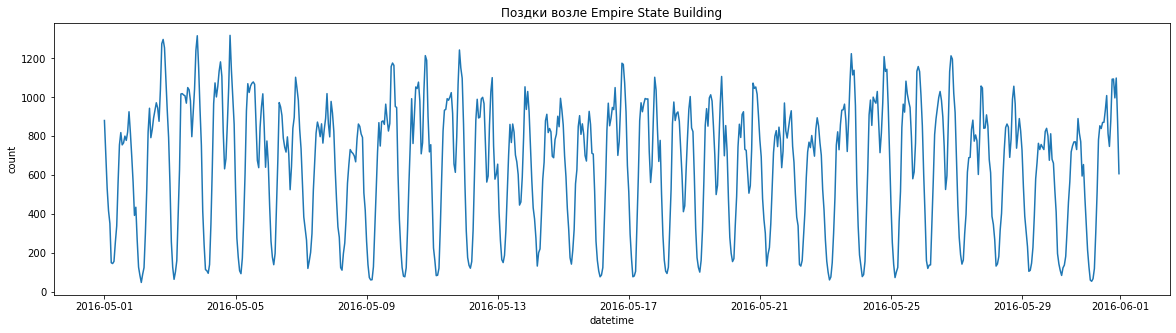

In [19]:
plt.figure(figsize=(20, 5))
sns.lineplot(data_esb['datetime'], data_esb['count'])
plt.title('Поздки возле Empire State Building')

In [20]:
print('Пар час-ячейка без поездок {}'.format((data_full['count'] == 0).sum()))

Пар час-ячейка без поездок 1718238
